In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Subset
from torchvision import models
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAUROC
from collections import Counter
from scipy.stats import wilcoxon,ttest_rel,friedmanchisquare,f_oneway,kruskal
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import timm

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%pip install scikit-posthocs

In [3]:
import scikit_posthocs as sp

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(root="./Brain MRI ND-5 Dataset/tumordata/Training", transform=transform)
test_dataset = datasets.ImageFolder(root="./Brain MRI ND-5 Dataset/tumordata/Testing", transform=transform)


In [18]:
ext_train_dataset = datasets.ImageFolder(root="./MRI Dataset (Tumor)/Training", transform=transform)
ext_test_dataset = datasets.ImageFolder(root="./MRI Dataset (Tumor)/Testing", transform=transform)


In [8]:
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

In [9]:
ext_train_labels = [label for _, label in ext_train_dataset]
ext_test_labels = [label for _, label in ext_test_dataset]

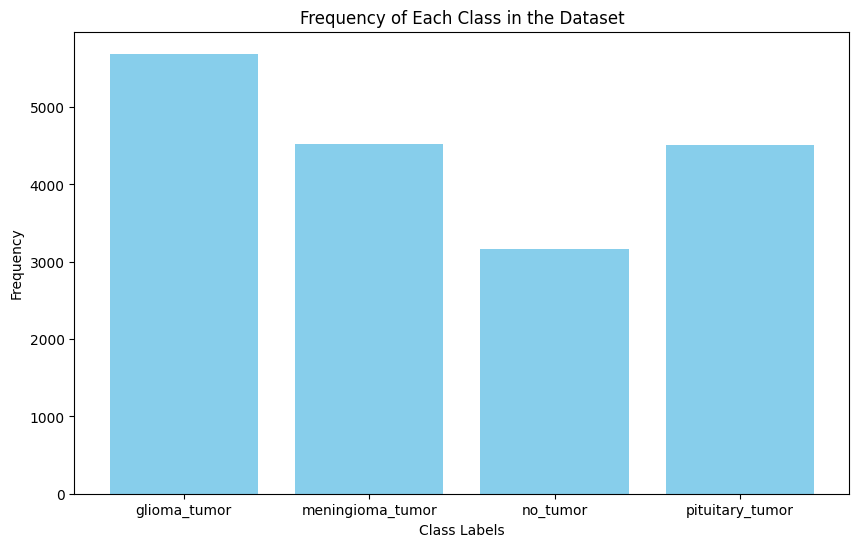

In [10]:
all_labels = train_labels + test_labels
label_counts = Counter(all_labels)
labels = list(label_counts.keys())
counts = list(label_counts.values())
class_names = train_dataset.classes
mapped_labels = [class_names[label] for label in labels]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(mapped_labels, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class in the Dataset')
plt.show()

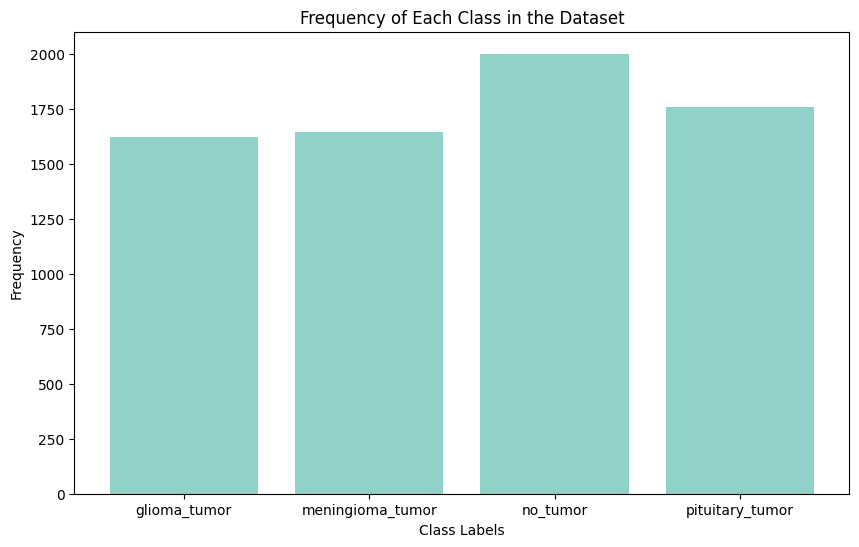

In [45]:
all_labels = ext_train_labels + ext_test_labels
label_counts = Counter(all_labels)
labels = list(label_counts.keys())
counts = list(label_counts.values())
class_names = train_dataset.classes
mapped_labels = [class_names[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.bar(mapped_labels, counts, color='#90D1CA')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class in the Dataset')
plt.show()

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
class XceptionCustom(nn.Module):
    def __init__(self, num_classes=4):
        super(XceptionCustom, self).__init__()
        
        # Load pretrained Xception
        self.encoder = timm.create_model('xception', pretrained=True, num_classes=0)
        self.flatten_dim = self.encoder.num_features  # Typically 2048 for Xception
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.flatten_dim),
            nn.Linear(self.flatten_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)  # Extract features
        x = self.classifier(x)
        return x

# Instantiate model
model = XceptionCustom(num_classes=4)

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [9]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        base_model = models.vgg16(pretrained=True)
        self.encoder = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.flatten_dim = 512 
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.flatten_dim),
            nn.Linear(self.flatten_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

In [10]:
class EfficientNet_Attention(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNet_Attention, self).__init__()
        self.encoder = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)  
        self.attention = nn.Sequential(
            nn.Linear(1536, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1536),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.7),  # Increase dropout
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.encoder(x)  # EfficientNet features
        attn = self.attention(x)  
        x = x * attn  # Apply attention weights
        x = self.classifier(x)
        return x

model = EfficientNet_Attention(num_classes=4)


In [11]:
class VGG19(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG19, self).__init__()
        base_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.encoder = base_model.features
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder[28:].parameters():
            param.requires_grad = True
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.flatten_dim = 512
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.flatten_dim),
            nn.Linear(self.flatten_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
vgg16 = VGG16()
vgg16.load_state_dict(torch.load("vgg16_tumor.pth", map_location='cuda'))
vgg16.eval()

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\2942417458.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code du

VGG16(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [14]:
vgg19 = VGG19()
vgg19.load_state_dict(torch.load("vgg19_tumor.pth", map_location='cuda'))
vgg19.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\3703055625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg19.load_state_dict(torch.load("vgg19_tumor.pth", ma

VGG19(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [15]:
xce = XceptionCustom()
xce.load_state_dict(torch.load("Xception_tumor.pth", map_location='cuda'))
xce.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\2637466097.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xce.load_state_dict(torch.load("Xception_tumor.pth", m

XceptionCustom(
  (encoder): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

In [16]:
Eff = EfficientNet_Attention()
Eff.load_state_dict(torch.load("EfficientNetAttention_tumor.pth", map_location='cuda'))
Eff.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\2607650036.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Eff.load_state_dict(torch.load("EfficientNetAttention_

EfficientNet_Attention(
  (encoder): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          

In [17]:
cnn = CNNModel(4)
cnn.load_state_dict(torch.load("CNN_tumor.pth", map_location='cuda'))
cnn.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\1360665492.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load("CNN_tumor.pth", map_lo

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [18]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [19]:
torch.cuda.empty_cache()

In [20]:
torch.nn.utils.clip_grad_norm_(xce.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(vgg16.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(Eff.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(vgg19.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm=1.0)

tensor(0.)

In [21]:
xce = xce.to(device)
vgg16 = vgg16.to(device)
Eff = Eff.to(device)
vgg19 = vgg19.to(device)
cnn = cnn.to(device)

In [22]:

Xception_Metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Evaluating fold {fold + 1}")
    val_subset = Subset(train_dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)

    # Load model
    xce = xce.to(device)
    xce.load_state_dict(torch.load(f"./checkpoints_Xception/fold_{fold+1}/best_model.pth"))
    xce.eval()

    # Initialize metrics
    accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
    precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
    recall = MulticlassRecall(num_classes=4, average='macro').to(device)
    f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
    auc = MulticlassAUROC(num_classes=4, average='macro').to(device)

    # Loop through val_loader
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = xce(inputs)

            # Update each metric
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)
            auc.update(outputs, labels)

    # Compute final metrics for the fold
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy.compute().item(),
        'precision': precision.compute().item(),
        'recall': recall.compute().item(),
        'f1': f1.compute().item(),
        'roc_auc': auc.compute().item()
    }

    print(f"Fold {fold + 1} metrics:", metrics)
    Xception_Metrics.append(metrics)

    # Reset metrics (recommended)
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()
    auc.reset()




Evaluating fold 1


C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23768\2386134761.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xce.load_state_dict(torch.load(f"./checkpoints_Xcepti

KeyboardInterrupt: 

In [26]:

VGG16_Metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Evaluating fold {fold + 1}")
    val_subset = Subset(train_dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)

    # Load model
    vgg16 = vgg16.to(device)
    vgg16.load_state_dict(torch.load(f"./checkpoints_VGG16/fold_{fold+1}/best_model.pth"))
    vgg16.eval()

    # Initialize metrics
    accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
    precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
    recall = MulticlassRecall(num_classes=4, average='macro').to(device)
    f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
    auc = MulticlassAUROC(num_classes=4, average='macro').to(device)

    # Loop through val_loader
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)

            # Update each metric
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)
            auc.update(outputs, labels)

    # Compute final metrics for the fold
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy.compute().item(),
        'precision': precision.compute().item(),
        'recall': recall.compute().item(),
        'f1': f1.compute().item(),
        'roc_auc': auc.compute().item()
    }

    print(f"Fold {fold + 1} metrics:", metrics)
    VGG16_Metrics.append(metrics)

    # Reset metrics (recommended)
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()
    auc.reset()




Evaluating fold 1


C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23160\1028847349.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load(f"./checkpoints_VGG1

Fold 1 metrics: {'fold': 1, 'accuracy': 0.9660963416099548, 'precision': 0.9648345708847046, 'recall': 0.9660963416099548, 'f1': 0.9652938842773438, 'roc_auc': 0.9972156286239624}
Evaluating fold 2
Fold 2 metrics: {'fold': 2, 'accuracy': 0.9708629846572876, 'precision': 0.9755645990371704, 'recall': 0.9708629846572876, 'f1': 0.9724966287612915, 'roc_auc': 0.9995741844177246}
Evaluating fold 3
Fold 3 metrics: {'fold': 3, 'accuracy': 0.9972652196884155, 'precision': 0.9976372122764587, 'recall': 0.9972652196884155, 'f1': 0.9974460601806641, 'roc_auc': 0.9999701380729675}
Evaluating fold 4
Fold 4 metrics: {'fold': 4, 'accuracy': 0.9992877244949341, 'precision': 0.9993113279342651, 'recall': 0.9992877244949341, 'f1': 0.9992985725402832, 'roc_auc': 0.9999972581863403}
Evaluating fold 5
Fold 5 metrics: {'fold': 5, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 6
Fold 6 metrics: {'fold': 6, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1

In [27]:

EfficientNet_Attn_Metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Evaluating fold {fold + 1}")
    val_subset = Subset(train_dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)

    # Load model
    Eff = Eff.to(device)
    Eff.load_state_dict(torch.load(f"./checkpoints/fold_{fold+1}/best_model.pth"))
    Eff.eval()

    # Initialize metrics
    accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
    precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
    recall = MulticlassRecall(num_classes=4, average='macro').to(device)
    f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
    auc = MulticlassAUROC(num_classes=4, average='macro').to(device)

    # Loop through val_loader
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = Eff(inputs)

            # Update each metric
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)
            auc.update(outputs, labels)

    # Compute final metrics for the fold
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy.compute().item(),
        'precision': precision.compute().item(),
        'recall': recall.compute().item(),
        'f1': f1.compute().item(),
        'roc_auc': auc.compute().item()
    }

    print(f"Fold {fold + 1} metrics:", metrics)
    EfficientNet_Attn_Metrics.append(metrics)

    # Reset metrics (recommended)
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()
    auc.reset()




Evaluating fold 1


C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23160\1793789646.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Eff.load_state_dict(torch.load(f"./checkpoints/fold_{

Fold 1 metrics: {'fold': 1, 'accuracy': 0.9912527799606323, 'precision': 0.9904661178588867, 'recall': 0.9912527799606323, 'f1': 0.9908505082130432, 'roc_auc': 0.9998302459716797}
Evaluating fold 2
Fold 2 metrics: {'fold': 2, 'accuracy': 0.9994577169418335, 'precision': 0.9992977380752563, 'recall': 0.9994577169418335, 'f1': 0.9993769526481628, 'roc_auc': 1.0}
Evaluating fold 3
Fold 3 metrics: {'fold': 3, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 4
Fold 4 metrics: {'fold': 4, 'accuracy': 0.9992877244949341, 'precision': 0.9993113279342651, 'recall': 0.9992877244949341, 'f1': 0.9992985725402832, 'roc_auc': 1.0}
Evaluating fold 5
Fold 5 metrics: {'fold': 5, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 6
Fold 6 metrics: {'fold': 6, 'accuracy': 0.9992711544036865, 'precision': 0.9993206262588501, 'recall': 0.9992711544036865, 'f1': 0.9992948770523071, 'roc_auc': 0.999946117401123}
Evaluating 

In [28]:

VGG19_Metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Evaluating fold {fold + 1}")
    val_subset = Subset(train_dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)

    # Load model
    vgg19 = vgg19.to(device)
    vgg19.load_state_dict(torch.load(f"./checkpoints_VGG19/fold_{fold+1}/best_model.pth"))
    vgg19.eval()

    # Initialize metrics
    accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
    precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
    recall = MulticlassRecall(num_classes=4, average='macro').to(device)
    f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
    auc = MulticlassAUROC(num_classes=4, average='macro').to(device)

    # Loop through val_loader
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg19(inputs)

            # Update each metric
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)
            auc.update(outputs, labels)

    # Compute final metrics for the fold
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy.compute().item(),
        'precision': precision.compute().item(),
        'recall': recall.compute().item(),
        'f1': f1.compute().item(),
        'roc_auc': auc.compute().item()
    }

    print(f"Fold {fold + 1} metrics:", metrics)
    VGG19_Metrics.append(metrics)
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()
    auc.reset()




Evaluating fold 1


C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_23160\556475144.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg19.load_state_dict(torch.load(f"./checkpoints_VGG19

Fold 1 metrics: {'fold': 1, 'accuracy': 0.9935312867164612, 'precision': 0.9936453104019165, 'recall': 0.9935312867164612, 'f1': 0.9935859441757202, 'roc_auc': 0.9999001622200012}
Evaluating fold 2
Fold 2 metrics: {'fold': 2, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 3
Fold 3 metrics: {'fold': 3, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 4
Fold 4 metrics: {'fold': 4, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 5
Fold 5 metrics: {'fold': 5, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 6
Fold 6 metrics: {'fold': 6, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 7
Fold 7 metrics: {'fold': 7, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Evaluating fold 8
Fold 8 metrics: {'fold': 8, 'accuracy': 1.0, 'precision': 1.0, '

In [29]:
def extract_metric_list(all_metrics, metric):
    return [fold_metrics[metric] for fold_metrics in all_metrics]

In [30]:
acc_xce = extract_metric_list(Xception_Metrics, 'accuracy')
acc_vgg16 = extract_metric_list(VGG16_Metrics, 'accuracy')
acc_vgg19 = extract_metric_list(VGG19_Metrics, 'accuracy')
acc_eff = extract_metric_list(EfficientNet_Attn_Metrics, 'accuracy')

pre_xce = extract_metric_list(Xception_Metrics, 'precision')
pre_vgg16 = extract_metric_list(VGG16_Metrics, 'precision')
pre_vgg19 = extract_metric_list(VGG19_Metrics, 'precision')
pre_eff = extract_metric_list(EfficientNet_Attn_Metrics, 'precision')

rec_xce = extract_metric_list(Xception_Metrics, 'recall')
rec_vgg16 = extract_metric_list(VGG16_Metrics, 'recall')
rec_vgg19 = extract_metric_list(VGG19_Metrics, 'recall')
rec_eff = extract_metric_list(EfficientNet_Attn_Metrics, 'recall')

f1_xce = extract_metric_list(Xception_Metrics, 'f1')
f1_vgg16 = extract_metric_list(VGG16_Metrics, 'f1')
f1_vgg19 = extract_metric_list(VGG19_Metrics, 'f1')
f1_eff = extract_metric_list(EfficientNet_Attn_Metrics, 'f1')

auc_xce = extract_metric_list(Xception_Metrics, 'roc_auc')
auc_vgg16 = extract_metric_list(VGG16_Metrics, 'roc_auc')
auc_vgg19 = extract_metric_list(VGG19_Metrics, 'roc_auc')
auc_eff = extract_metric_list(EfficientNet_Attn_Metrics, 'roc_auc')

In [31]:
def run_kruskal_tests(metric_name, m1, m2, m3,m4):
    h_stat, p_value = kruskal(m1, m2, m3,m4)
    print(f"\n{metric_name} Kruskal-Wallis Test:")
    print(f"H-statistic: {h_stat:.4f}, p-value: {p_value:.4f}")

In [32]:
def run_anova_tests(metric_name, m1, m2, m3,m4):
    f_stat, p_value = f_oneway(m1, m2, m3,m4)
    print(f"\n{metric_name} ANOVA Test:")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

In [33]:
def run_pairwise_ttests(metric_name, m1, m2, m3,m4):
    p_xv = ttest_rel(m1, m2).pvalue
    p_xe = ttest_rel(m1, m3).pvalue
    p_ve = ttest_rel(m2, m3).pvalue
    p_vv = ttest_rel(m2, m4).pvalue
    p_v2e = ttest_rel(m4, m3).pvalue
    p_v2x = ttest_rel(m4, m1).pvalue
    
    print(f"\n{metric_name} Comparison:")
    print(f"Xception vs VGG16: p={p_xv:.4f}")
    print(f"Xception vs EfficientNet: p={p_xe:.4f}")
    print(f"VGG16 vs EfficientNet: p={p_ve:.4f}")
    print(f"VGG16 vs VGG19: p={p_vv:.4f}")
    print(f"VGG19 vs EfficientNet: p={p_v2e:.4f}")
    print(f"VGG19 vs Xception: p={p_v2x:.4f}")
    


In [34]:
def run_pairwise_tests(metric_name, m1, m2, m3,m4):
    p_xv = wilcoxon(m1, m2).pvalue
    p_xe = wilcoxon(m1, m3).pvalue
    p_ve = wilcoxon(m2, m3).pvalue
    p_vv = wilcoxon(m2, m4).pvalue
    p_v2e = wilcoxon(m4, m3).pvalue
    p_v2x = wilcoxon(m4, m1).pvalue
    
    print(f"\n{metric_name} Comparison:")
    print(f"Xception vs VGG16: p={p_xv:.4f}")
    print(f"Xception vs EfficientNet: p={p_xe:.4f}")
    print(f"VGG16 vs EfficientNet: p={p_ve:.4f}")
    print(f"VGG16 vs VGG19: p={p_vv:.4f}")
    print(f"VGG19 vs EfficientNet: p={p_v2e:.4f}")
    print(f"VGG19 vs Xception: p={p_v2x:.4f}")

In [35]:
run_pairwise_tests("Accuracy", acc_xce, acc_vgg16, acc_eff,acc_vgg19)
run_pairwise_tests("Precision", pre_xce, pre_vgg16, pre_eff,pre_vgg19)
run_pairwise_tests("Recall", rec_xce, rec_vgg16, rec_eff,rec_vgg19)
run_pairwise_tests("F1", f1_xce, f1_vgg16, f1_eff,f1_vgg19)
run_pairwise_tests("ROC-AUC", auc_xce, auc_vgg16, auc_eff, auc_vgg19)



Accuracy Comparison:
Xception vs VGG16: p=0.1159
Xception vs EfficientNet: p=0.5930
VGG16 vs EfficientNet: p=0.1380
VGG16 vs VGG19: p=0.0431
VGG19 vs EfficientNet: p=0.0679
VGG19 vs Xception: p=0.2850

Precision Comparison:
Xception vs VGG16: p=0.0747
Xception vs EfficientNet: p=0.5930
VGG16 vs EfficientNet: p=0.1380
VGG16 vs VGG19: p=0.0431
VGG19 vs EfficientNet: p=0.0679
VGG19 vs Xception: p=0.2850

Recall Comparison:
Xception vs VGG16: p=0.1159
Xception vs EfficientNet: p=0.5930
VGG16 vs EfficientNet: p=0.1380
VGG16 vs VGG19: p=0.0431
VGG19 vs EfficientNet: p=0.0679
VGG19 vs Xception: p=0.2850

F1 Comparison:
Xception vs VGG16: p=0.1159
Xception vs EfficientNet: p=0.5930
VGG16 vs EfficientNet: p=0.1380
VGG16 vs VGG19: p=0.0431
VGG19 vs EfficientNet: p=0.0679
VGG19 vs Xception: p=0.2850

ROC-AUC Comparison:
Xception vs VGG16: p=0.0431
Xception vs EfficientNet: p=0.2850
VGG16 vs EfficientNet: p=0.1159
VGG16 vs VGG19: p=0.0431
VGG19 vs EfficientNet: p=0.1797
VGG19 vs Xception: p=0.654

In [36]:
run_pairwise_ttests("Accuracy", acc_xce, acc_vgg16, acc_eff,acc_vgg19)
run_pairwise_ttests("Precision", pre_xce, pre_vgg16, pre_eff,pre_vgg19)
run_pairwise_ttests("Recall", rec_xce, rec_vgg16, rec_eff,rec_vgg19)
run_pairwise_ttests("F1", f1_xce, f1_vgg16, f1_eff,f1_vgg19)
run_pairwise_ttests("ROC-AUC", auc_xce, auc_vgg16, auc_eff, auc_vgg19)


Accuracy Comparison:
Xception vs VGG16: p=0.1422
Xception vs EfficientNet: p=0.3880
VGG16 vs EfficientNet: p=0.1481
VGG16 vs VGG19: p=0.1373
VGG19 vs EfficientNet: p=0.0953
VGG19 vs Xception: p=0.2082

Precision Comparison:
Xception vs VGG16: p=0.1458
Xception vs EfficientNet: p=0.3665
VGG16 vs EfficientNet: p=0.1480
VGG16 vs VGG19: p=0.1394
VGG19 vs EfficientNet: p=0.1271
VGG19 vs Xception: p=0.2231

Recall Comparison:
Xception vs VGG16: p=0.1422
Xception vs EfficientNet: p=0.3880
VGG16 vs EfficientNet: p=0.1481
VGG16 vs VGG19: p=0.1373
VGG19 vs EfficientNet: p=0.0953
VGG19 vs Xception: p=0.2082

F1 Comparison:
Xception vs VGG16: p=0.1432
Xception vs EfficientNet: p=0.3759
VGG16 vs EfficientNet: p=0.1478
VGG16 vs VGG19: p=0.1380
VGG19 vs EfficientNet: p=0.1121
VGG19 vs Xception: p=0.2041

ROC-AUC Comparison:
Xception vs VGG16: p=0.1845
Xception vs EfficientNet: p=0.3454
VGG16 vs EfficientNet: p=0.1852
VGG16 vs VGG19: p=0.1810
VGG19 vs EfficientNet: p=0.1718
VGG19 vs Xception: p=0.471

In [37]:
run_anova_tests("Accuracy", acc_xce, acc_vgg16, acc_eff,acc_vgg19)
run_anova_tests("Precision", pre_xce, pre_vgg16, pre_eff,pre_vgg19)
run_anova_tests("Recall", rec_xce, rec_vgg16, rec_eff,rec_vgg19)
run_anova_tests("F1", f1_xce, f1_vgg16, f1_eff,f1_vgg19)
run_anova_tests("ROC-AUC", auc_xce, auc_vgg16, auc_eff, auc_vgg19)


Accuracy ANOVA Test:
F-statistic: 1.8248, p-value: 0.1601

Precision ANOVA Test:
F-statistic: 1.6933, p-value: 0.1857

Recall ANOVA Test:
F-statistic: 1.8248, p-value: 0.1601

F1 ANOVA Test:
F-statistic: 1.7767, p-value: 0.1690

ROC-AUC ANOVA Test:
F-statistic: 1.8996, p-value: 0.1471


In [38]:
run_kruskal_tests("Accuracy", acc_xce, acc_vgg16, acc_eff,acc_vgg19)
run_kruskal_tests("Precision", pre_xce, pre_vgg16, pre_eff,pre_vgg19)
run_kruskal_tests("Recall", rec_xce, rec_vgg16, rec_eff,rec_vgg19)
run_kruskal_tests("F1", f1_xce, f1_vgg16, f1_eff,f1_vgg19)
run_kruskal_tests("ROC-AUC", auc_xce, auc_vgg16, auc_eff, auc_vgg19)


Accuracy Kruskal-Wallis Test:
H-statistic: 3.5191, p-value: 0.3183

Precision Kruskal-Wallis Test:
H-statistic: 3.6174, p-value: 0.3059

Recall Kruskal-Wallis Test:
H-statistic: 3.5191, p-value: 0.3183

F1 Kruskal-Wallis Test:
H-statistic: 3.4567, p-value: 0.3264

ROC-AUC Kruskal-Wallis Test:
H-statistic: 4.9286, p-value: 0.1771


In [5]:
def cohens_d(x, y):
    dx = np.std(x)
    dy = np.std(y)
    pooled_std = np.sqrt(((len(x) - 1) * dx**2 + (len(y) - 1) * dy**2) / (len(x) + len(y) - 2))
    return np.abs(np.mean(x) - np.mean(y)) / pooled_std

In [6]:
CNN = [95.96,95.82,96.32,96.07]
VGG16 = [95.94, 95.83, 96.21, 96.02]
VGG19 = [96.36,96.27,96.78,96.52]
Xception = [95.81, 95.78, 96.21, 95.99]
EfficientNet = [97.45, 97.29, 97.79, 97.54]

In [7]:
d_value = cohens_d(CNN,VGG16)
print(f"Cohen's d between CNN and VGG16: {d_value:.4f}")
d_value = cohens_d(CNN,Xception)
print(f"Cohen's d between CNN and Xception: {d_value:.4f}")
d_value = cohens_d(CNN,EfficientNet)
print(f"Cohen's d between CNN and EfficientNet-Attn: {d_value:.4f}")
d_value = cohens_d(CNN,VGG19)
print(f"Cohen's d between CNN and VGG19: {d_value:.4f}")
d_value = cohens_d(Xception,VGG16)
print(f"Cohen's d between Xception and VGG16: {d_value:.4f}")
d_value = cohens_d(Xception,VGG19)
print(f"Cohen's d between Xception and VGG19: {d_value:.4f}")
d_value = cohens_d(Xception, EfficientNet)
print(f"Cohen's d between Xception and EfficientNet-Attn: {d_value:.4f}")
d_value = cohens_d(VGG16, EfficientNet)
print(f"Cohen's d between VGG16 and EfficientNet-Attn: {d_value:.4f}")
d_value = cohens_d(VGG16, VGG19)
print(f"Cohen's d between VGG16 and VGG19: {d_value:.4f}")
d_value = cohens_d(VGG19, EfficientNet)
print(f"Cohen's d between VGG19 and EfficientNet-Attn: {d_value:.4f}")


Cohen's d between CNN and VGG16: 0.2616
Cohen's d between CNN and Xception: 0.5355
Cohen's d between CNN and EfficientNet-Attn: 8.1020
Cohen's d between CNN and VGG19: 2.3347
Cohen's d between Xception and VGG16: 0.3365
Cohen's d between Xception and VGG19: 2.9244
Cohen's d between Xception and EfficientNet-Attn: 8.9035
Cohen's d between VGG16 and EfficientNet-Attn: 9.4094
Cohen's d between VGG16 and VGG19: 2.8639
Cohen's d between VGG19 and EfficientNet-Attn: 5.5210


In [8]:

data = np.array([CNN,VGG16,VGG19,Xception, EfficientNet]).T
stat, p = friedmanchisquare(data[:, 0], data[:, 1], data[:, 2],data[:,3], data[:,4])
print("Friedman test p-value:", p)
if p < 0.05:
    print("→ Significant difference found. Performing Nemenyi post-hoc test.")
    
    df = pd.DataFrame(data, columns=['CNN','VGG16','VGG19', 'Xception', 'EfficientNet'])
    nemenyi_result = sp.posthoc_nemenyi_friedman(df)
    print("\nNemenyi Post-hoc Results (p-values):\n", nemenyi_result)
else:
    print("→ No significant difference among models based on Friedman test.")

Friedman test p-value: 0.004420966981525489
→ Significant difference found. Performing Nemenyi post-hoc test.

Nemenyi Post-hoc Results (p-values):
                    CNN     VGG16     VGG19  Xception  EfficientNet
CNN           1.000000  0.980845  0.797105  0.592901      0.259863
VGG16         0.980845  1.000000  0.448214  0.899078      0.075683
VGG19         0.797105  0.448214  1.000000  0.075683      0.899078
Xception      0.592901  0.899078  0.075683  1.000000      0.004802
EfficientNet  0.259863  0.075683  0.899078  0.004802      1.000000


In [10]:
ext_CNN = [98.79,98.75,98.71,98.73]
ext_VGG16 = [99.32, 99.28, 99.28, 99.28]
ext_VGG19 = [99.52,99.49,99.48,99.49]
ext_Xception = [99.25, 99.21, 99.22, 99.22]
ext_EfficientNet = [99.82, 99.82, 99.81, 99.82]

In [11]:
ext_data = np.array([ext_CNN,ext_VGG16,ext_VGG19, ext_Xception, ext_EfficientNet]).T
stat, p = friedmanchisquare(data[:, 0], data[:, 1], data[:, 2],data[:,3],data[:,4])
print("Friedman test p-value:", p)

if p < 0.05:
    print("→ Significant difference found. Performing Nemenyi post-hoc test.")
    
    df_ext = pd.DataFrame(ext_data, columns=['ext_CNN','ext_VGG16','ext_VGG19', 'ext_Xception', 'ext_EfficientNet'])
    nemenyi_result = sp.posthoc_nemenyi_friedman(df_ext)
    print("\nNemenyi Post-hoc Results (p-values):\n", nemenyi_result)
else:
    print("→ No significant difference among models based on Friedman test.")

Friedman test p-value: 0.004420966981525489
→ Significant difference found. Performing Nemenyi post-hoc test.

Nemenyi Post-hoc Results (p-values):
                    ext_CNN  ext_VGG16  ext_VGG19  ext_Xception  \
ext_CNN           1.000000   0.380025   0.056432      0.899078   
ext_VGG16         0.380025   1.000000   0.899078      0.899078   
ext_VGG19         0.056432   0.899078   1.000000      0.380025   
ext_Xception      0.899078   0.899078   0.380025      1.000000   
ext_EfficientNet  0.003193   0.380025   0.899078      0.056432   

                  ext_EfficientNet  
ext_CNN                   0.003193  
ext_VGG16                 0.380025  
ext_VGG19                 0.899078  
ext_Xception              0.056432  
ext_EfficientNet          1.000000  


In [23]:
CNN_Metric = pd.read_csv('checkpoints_CNN/kfold_metrics.csv')
VGG16_Metric = pd.read_csv('checkpoints_VGG16/kfold_metrics.csv')
VGG19_Metric = pd.read_csv('checkpoints_VGG19/kfold_metrics.csv')
Xception_Metric = pd.read_csv('checkpoints_Xception/kfold_metrics.csv')
EfficientNet_Metric = pd.read_csv('checkpoints/kfold_metrics.csv')


In [ ]:
def normalise_min_max(df,col):
    new_metric = (df[col] - df[col].mean())/df[col].std()
    df['Normalised Loss'] = new_metric

In [59]:
normalise_min_max(EfficientNet_Metric,'val_loss')

In [24]:
EfficientNet_Metric

,fold,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,1,0.280687,0.909571,0.909513,0.909571,0.909539,0.985675,1.109789e-01,0.964415,0.968425,0.964415,0.966197,0.997156
1,1,2,0.109720,0.966989,0.966925,0.966989,0.966956,0.997298,8.740619e-02,0.977605,0.973934,0.977605,0.975394,0.998532
2,1,3,0.079654,0.977921,0.978138,0.977921,0.978029,0.998276,7.411304e-02,0.983432,0.981447,0.983432,0.982348,0.998051
3,1,4,0.131871,0.970485,0.970510,0.970485,0.970497,0.997361,1.635345e-01,0.984145,0.985350,0.984145,0.984682,0.998635
4,1,5,1.258568,0.801378,0.800373,0.801378,0.800840,0.937045,1.803987e+00,0.744216,0.795343,0.744216,0.738442,0.948739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,10,2,0.000015,1.000000,1.000000,1.000000,1.000000,1.000000,9.313181e-09,1.000000,1.000000,1.000000,1.000000,1.000000
118,10,3,0.000072,0.999882,0.999938,0.999882,0.999910,1.000000,9.821187e-09,1.000000,1.000000,1.000000,1.000000,1.000000
119,10,4,0.000005,1.000000,1.000000,1.000000,1.000000,1.000000,5.926582e-09,1.000000,1.000000,1.000000,1.000000,1.000000
120,10,5,0.000003,1.000000,1.000000,1.000000,1.000000,1.000000,9.567171e-09,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
mean_ta_eff = EfficientNet_Metric.groupby('fold').mean()['train_accuracy']
mean_va_eff = EfficientNet_Metric.groupby('fold').mean()['val_accuracy']
std_tl_eff = EfficientNet_Metric.groupby('fold').std()['train_loss']
std_vl_eff = EfficientNet_Metric.groupby('fold').std()['val_loss']

In [26]:
std_vl_eff

fold
1     3.540002e-01
2     1.495742e+03
3     4.716534e-03
4     4.112506e-03
5     1.138140e-03
6     4.497622e-03
7     1.431715e-03
8     3.467623e-07
9     1.510029e-09
10    2.772272e-09
Name: val_loss, dtype: float64

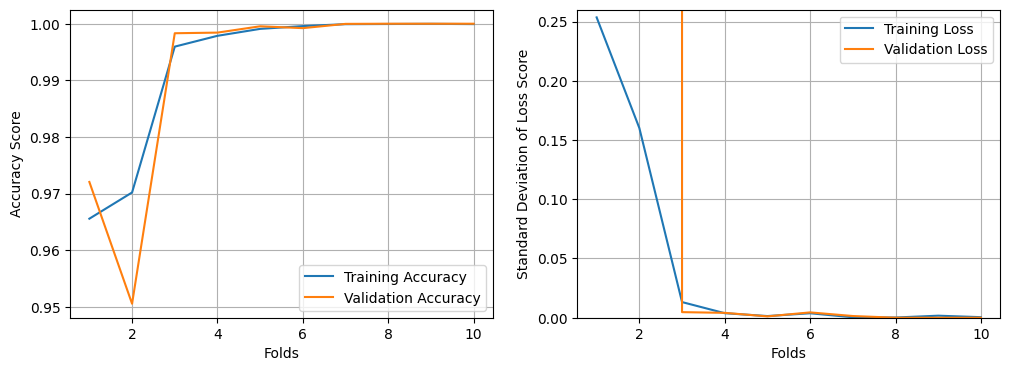

In [84]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy Score")
plt.plot(mean_ta_eff)
plt.plot(mean_va_eff)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
plt.ylim(0,0.26)
plt.xlabel("Folds")
plt.ylabel("Standard Deviation of Loss Score")
plt.plot(std_tl_eff)
plt.plot(std_vl_eff)

plt.grid()
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [27]:
mean_ta_cnn = CNN_Metric.groupby('fold').mean()['train_accuracy']
mean_va_cnn = CNN_Metric.groupby('fold').mean()['val_accuracy']
std_tl_cnn = CNN_Metric.groupby('fold').std()['train_loss']
std_vl_cnn = CNN_Metric.groupby('fold').std()['val_loss']

In [28]:
CNN_Metric.head()

,fold,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,1,1.023256,0.566588,0.557325,0.566588,0.560053,0.806137,0.714326,0.707046,0.722651,0.707046,0.706037,0.900211
1,1,2,0.720733,0.715821,0.696906,0.715821,0.703298,0.894859,0.533412,0.792642,0.772857,0.792642,0.773284,0.937246
2,1,3,0.585875,0.778967,0.762632,0.778967,0.768864,0.928806,0.495397,0.816152,0.807548,0.816152,0.798927,0.951913
3,1,4,0.484007,0.824448,0.810725,0.824448,0.816170,0.951075,0.511150,0.816094,0.830630,0.816094,0.814164,0.961823
4,1,5,0.406413,0.861147,0.851936,0.861147,0.855905,0.966335,0.334866,0.886992,0.875860,0.886992,0.878367,0.976878


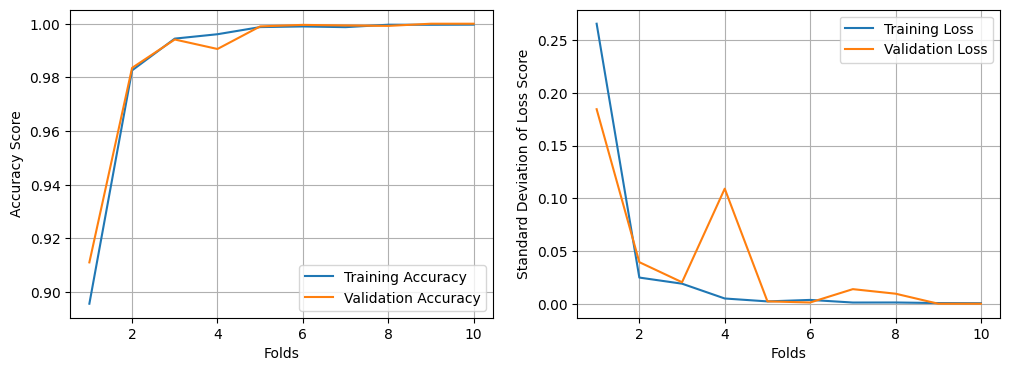

In [30]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy Score")
plt.plot(mean_ta_cnn)
plt.plot(mean_va_cnn)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
# plt.ylim(0,0.26)
plt.xlabel("Folds")
plt.ylabel("Standard Deviation of Loss Score")
plt.plot(std_tl_cnn)
plt.plot(std_vl_cnn)

plt.grid()
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [37]:
mean_ta_vgg16 = VGG16_Metric.groupby('fold').mean()['train_accuracy']
mean_va_vgg16 = VGG16_Metric.groupby('fold').mean()['val_accuracy']
std_tl_vgg16 = VGG16_Metric.groupby('fold').std()['train_loss']
std_vl_vgg16 = VGG16_Metric.groupby('fold').std()['val_loss']

In [39]:
std_tl_vgg16

fold
1     0.182177
2     0.021891
3     0.027425
4     0.008931
5     0.002995
6     0.001347
7     0.001272
8     0.000476
9     0.000428
10    0.000464
Name: train_loss, dtype: float64

In [34]:
VGG16_Metric

,fold,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,1,0.760984,0.697865,0.688622,0.697865,0.691075,0.891805,0.846098,0.626632,0.790156,0.626632,0.615845,0.939896
1,1,2,0.434373,0.839086,0.832971,0.839086,0.835465,0.960724,1.351335,0.625904,0.737846,0.625904,0.569248,0.941991
2,1,3,0.351176,0.870748,0.866352,0.870748,0.868219,0.974213,1.856052,0.881407,0.873035,0.881407,0.869936,0.977203
3,1,4,0.279372,0.897279,0.895465,0.897279,0.896275,0.983500,2.243607,0.764168,0.797063,0.764168,0.728667,0.974899
4,1,5,0.247933,0.917369,0.915487,0.917369,0.916374,0.987136,0.519025,0.803387,0.861842,0.803387,0.798773,0.989205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,10,7,0.000891,0.999686,0.999780,0.999686,0.999733,1.000000,0.290133,0.999415,0.999377,0.999415,0.999395,0.999280
97,10,8,0.001326,0.999765,0.999843,0.999765,0.999804,0.999988,2.039735,0.999415,0.999377,0.999415,0.999395,0.999274
98,10,9,0.000414,0.999860,0.999860,0.999860,0.999860,1.000000,4.216351,0.999415,0.999377,0.999415,0.999395,0.999272
99,10,10,0.001155,0.999686,0.999662,0.999686,0.999674,1.000000,33.071090,0.999415,0.999377,0.999415,0.999395,0.999277


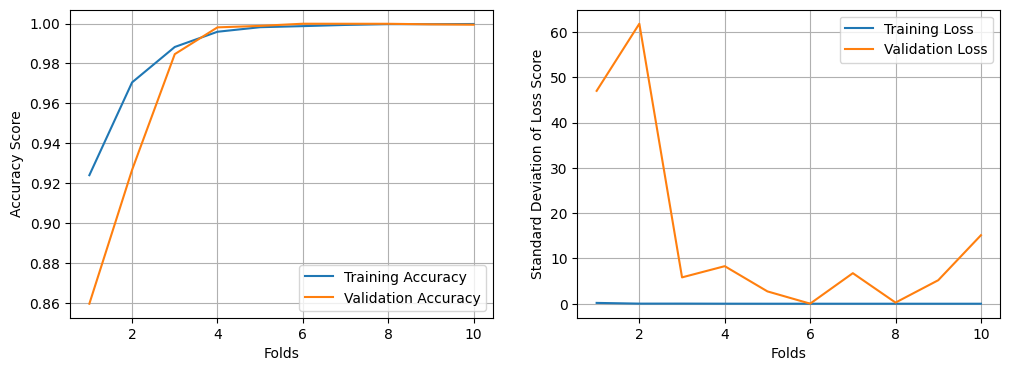

In [43]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy Score")
plt.plot(mean_ta_vgg16)
plt.plot(mean_va_vgg16)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
# plt.ylim(0,0.26)
plt.xlabel("Folds")
plt.ylabel("Standard Deviation of Loss Score")
plt.plot(std_tl_vgg16)
plt.plot(std_vl_vgg16)

plt.grid()
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [44]:
mean_ta_vgg19 = VGG19_Metric.groupby('fold').mean()['train_accuracy']
mean_va_vgg19 = VGG19_Metric.groupby('fold').mean()['val_accuracy']
std_tl_vgg19 = VGG19_Metric.groupby('fold').std()['train_loss']
std_vl_vgg19 = VGG19_Metric.groupby('fold').std()['val_loss']

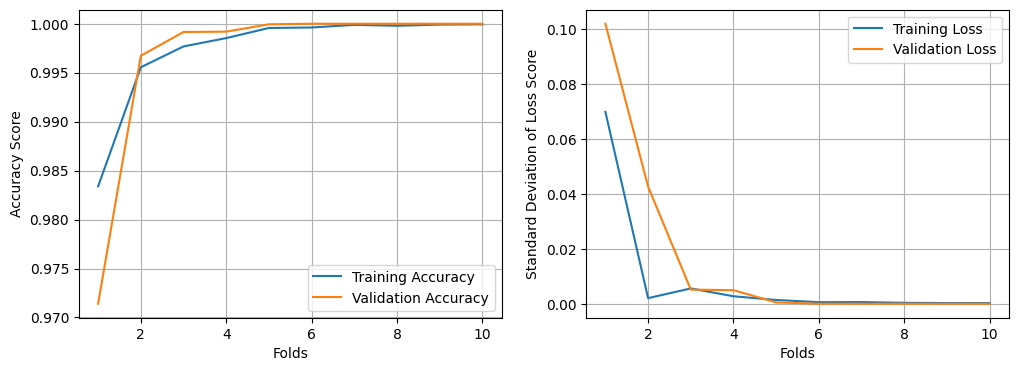

In [45]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy Score")
plt.plot(mean_ta_vgg19)
plt.plot(mean_va_vgg19)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
# plt.ylim(0,0.26)
plt.xlabel("Folds")
plt.ylabel("Standard Deviation of Loss Score")
plt.plot(std_tl_vgg19)
plt.plot(std_vl_vgg19)

plt.grid()
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [46]:
mean_ta_Xception = Xception_Metric.groupby('fold').mean()['train_accuracy']
mean_va_Xception = Xception_Metric.groupby('fold').mean()['val_accuracy']
std_tl_Xception = Xception_Metric.groupby('fold').std()['train_loss']
std_vl_Xception = Xception_Metric.groupby('fold').std()['val_loss']

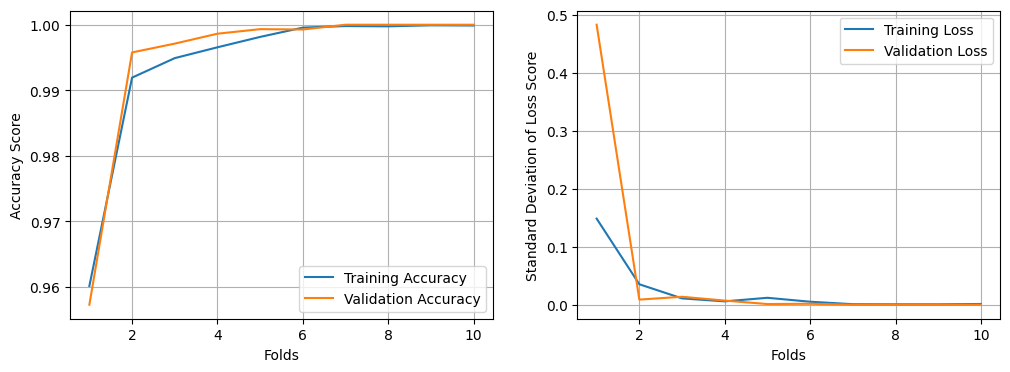

In [47]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy Score")
plt.plot(mean_ta_Xception)
plt.plot(mean_va_Xception)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
# plt.ylim(0,0.26)
plt.xlabel("Folds")
plt.ylabel("Standard Deviation of Loss Score")
plt.plot(std_tl_Xception)
plt.plot(std_vl_Xception)

plt.grid()
plt.legend(['Training Loss','Validation Loss'])
plt.show()

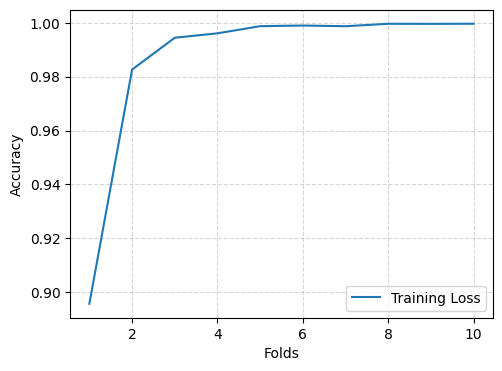

In [40]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.xlabel("Folds")
plt.ylabel("Accuracy")
plt.plot(mean_ta_cnn)
# plt.plot(mean_va_eff)
plt.grid()
plt.legend(['Training Accuracy','Validation Accuracy'])

# plt.subplot(1,2,2)
# plt.xlabel("Folds")
# plt.ylabel("Standard Deviation of Loss Score")
# plt.plot(std_tl_eff)
# plt.plot(std_vl_eff)

plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [36]:
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=16,persistent_workers=True)
test_loader_ext = DataLoader(ext_test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=16,persistent_workers=True)

In [ ]:
model_names = ['cnn','vgg16','vgg19','xce','Eff']
models = [cnn,vgg16,vgg19,xce,Eff]
all_metrics = {model: [] for model in model_names}

for fold, (train_idx, val_idx) in enumerate(kfold.split(test_dataset)):
    i = 0

    for model in models:
        model_name = model_names[i]
        print(f"{model_name}: Evaluating fold {fold + 1}")
        model.eval()
        accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
        precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
        recall = MulticlassRecall(num_classes=4, average='macro').to(device)
        f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
        auc = MulticlassAUROC(num_classes=4, average='macro').to(device)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=32,shuffle=False,pin_memory=True,num_workers=16,persistent_workers=True)  
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                accuracy.update(outputs, labels)
                precision.update(outputs, labels)
                recall.update(outputs, labels)
                f1.update(outputs, labels)
                auc.update(outputs, labels)

        metrics = {
        'model':model_name,
        'fold': fold + 1,
        'accuracy': accuracy.compute().item(),
        'precision': precision.compute().item(),
        'recall': recall.compute().item(),
        'f1': f1.compute().item(),
        'roc_auc': auc.compute().item()
        }
        print(f"Fold {fold + 1} metrics:", metrics)
        all_metrics[model].append(metrics)
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1.reset()
        auc.reset()
        i+=1
        
        


cnn: Evaluating fold 1
